<a href="https://colab.research.google.com/github/dmitry-kabanov/datascience/blob/main/keras/guides/keras_cv/2023-05-18-sd-in-keras-cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>High performance image generation using Stable Diffusion in KerasCV</h1>

# Overview

In [1]:
!pip install --upgrade keras-cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 15.3 MB/s eta 0:00:00


In [2]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

# Introduction

We construct the model and give it a prompt asking to generate several examples.

In [3]:
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [4]:
images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)

198180272/198180272 [==============================] - 1s 0us/step


In [5]:
def plot_images(images):
    for i in range(len(images)):
        plt.figure(figsize=(4, 4))
        # ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

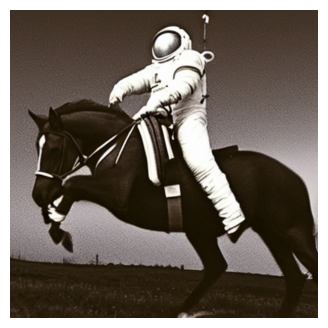

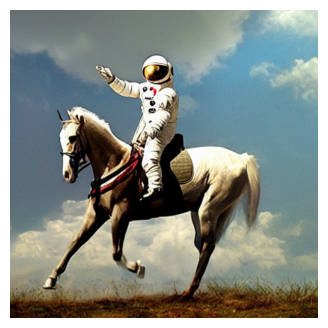

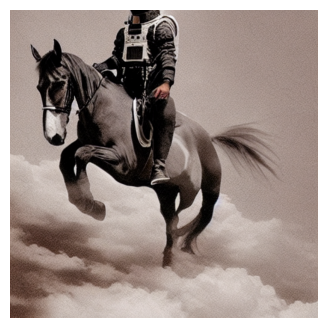

In [6]:
plot_images(images)

50/50 [==============================] - 36s 729ms/step


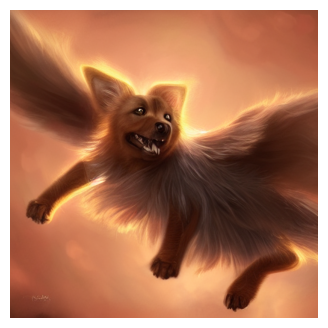

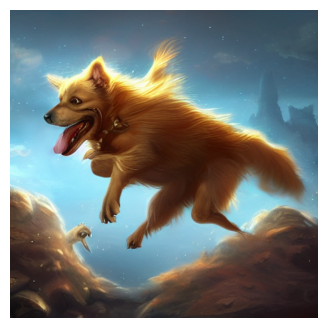

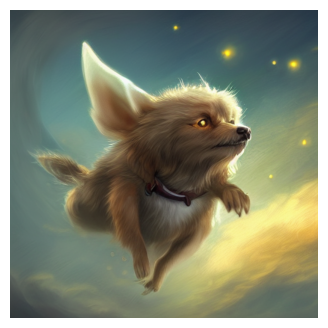

In [7]:
images = model.text_to_image(
    "cute magical flying dog, fantasy art, "
    "golden color, high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
plot_images(images)

# Performance in KerasCV implementation of Stable Diffusion

## Standard model

50/50 [==============================] - 39s 776ms/step
Standard model: {(end - start):.2f} seconds


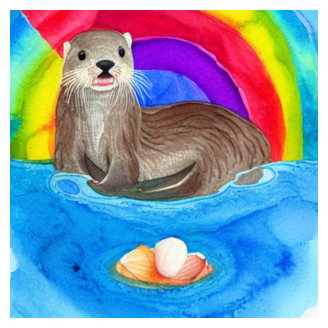

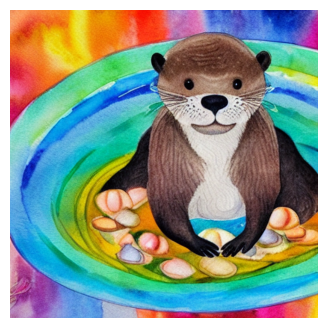

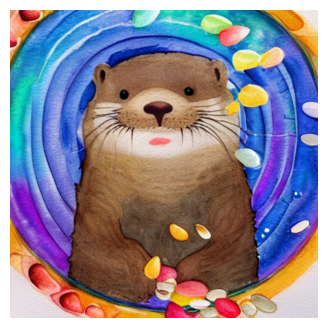

In [8]:
benchmark_result = []
start = time.time()
images = model.text_to_image(
    "A cute otter in a rainbow whirlpool holding shells, watercolor",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["Standard", end - start])
plot_images(images)

print(f"Standard model: {(end - start):.2f} seconds")
keras.backend.clear_session()  # Clear session to preserve memory

## Mixed precision

"Mixed precision" consists of performing computation using `float16` precision,
while storing weights in the `float32` format.
This is done to take advantage of the fact that `float16` operations are backed
by significantly faster kernels than their `float32` counterparts on modern
NVIDIA GPUs.

In [9]:
keras.mixed_precision.set_global_policy("mixed_float16")

In [10]:
model = keras_cv.models.StableDiffusion()

print("Compute dtype: ", model.diffusion_model.compute_dtype)
print(
    "Variable dtype: ", model.diffusion_model.variable_dtype,
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
Compute dtype:  float16
Variable dtype:  float32


50/50 [==============================] - 23s 454ms/step
Mixed precision model: 23.48 seconds


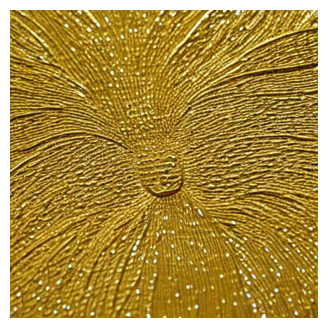

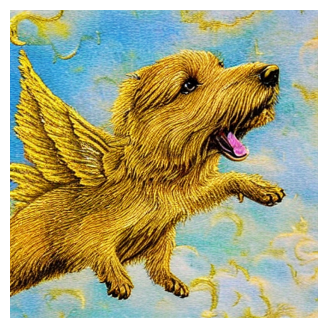

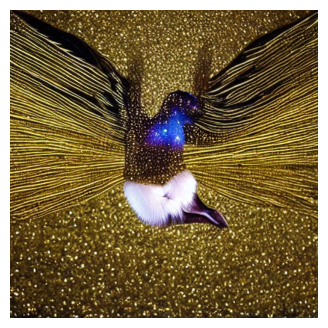

In [11]:
# Warm up the model.
model.text_to_image("warming up the model", batch_size=3)

start = time.time()
images = model.text_to_image(
    "a cute magical flying dog, fantasy art, "
    "golden color, high quality, highly detailed, elegant, sharp focus, ",
    "concept art, character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["Mixed precision", end - start])
plot_images(images)

print(f"Mixed precision model: {(end - start):.2f} seconds")
keras.backend.clear_session()

## XLA Compilation

TF has built-in XLA: Accelerated Linear Algebra compiler.
Try XLA by simply setting an argument while creating a model.

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
50/50 [==============================] - 173s 545ms/step


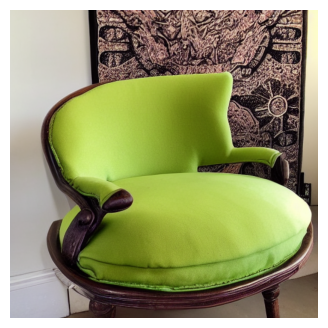

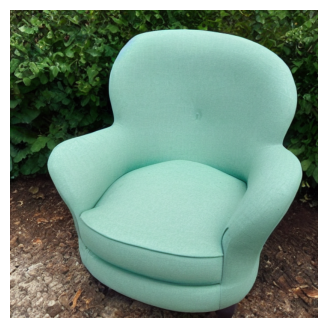

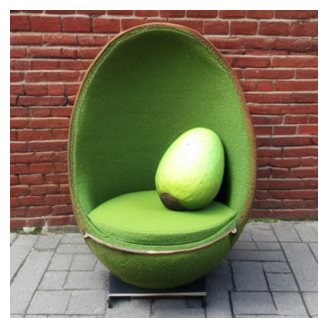

In [13]:
# Set back the default precision policy for benchmarking.
keras.mixed_precision.set_global_policy("float32")

model = keras_cv.models.StableDiffusion(jit_compile=True)
# Before we benchmark the model,
# we run inference once to make sure the TensorFlow
# graph was already been traced.
images = model.text_to_image("An avocado armchair", batch_size=3)
plot_images(images)


50/50 [==============================] - 28s 560ms/step
With XLA: 28.75 seconds


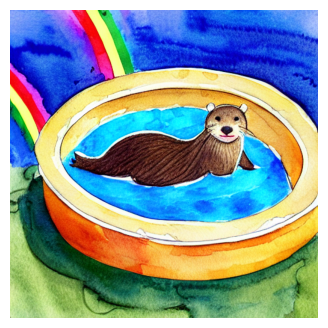

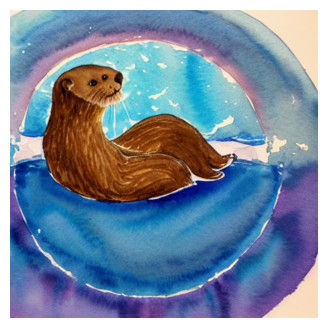

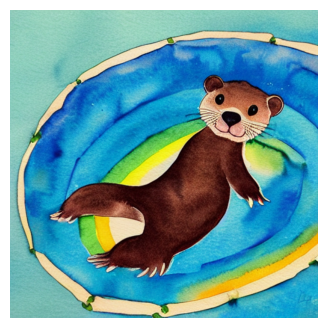

In [14]:
start = time.time()
images = model.text_to_image(
    "A Cute otter in a rainbow whirlpool hodling shells, watercolor",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["XLA", end - start])
plot_images(images)

print(f"With XLA: {(end - start):.2f} seconds")
keras.backend.clear_session()

## Mixed Precision `float16` + XLA

In [15]:
keras.mixed_precision.set_global_policy("mixed_float16")
model = keras_cv.models.StableDiffusion(jit_compile=True)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [ ]:
# Let's make sure to warm up the model
images = model.text_to_image(
    "Teddy bears conducting machine learning research",
    batch_size=3,
)
plot_images(images)


In [ ]:
start = time.time()
images = model.text_to_image(
    "A mysterious dark stranger visits the great pyramids of egypt, "
    "high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["XLA + Mixed Precision", end - start])
plot_images(images)

print(f"XLA + mixed precision: {(end - start):.2f} seconds")

## Results that I got on V100 on Colab

In [ ]:
# This code generates the results.
print("{:<20} {:<20}".format("Model", "Runtime"))
for result in benchmark_result:
    name, runtime = result
    print("{:<20} {:<20}".format(name, runtime))

## Results that I got on A100 on Colab